# EGARCH-SVM Hybrid Model

## Load Data

In [1]:
import numpy as np
import pandas as pd
from arch import arch_model
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
file_path = "..\data\ALGO_daily.csv"
df = pd.read_csv(file_path)
df.rename(columns={'timestamp': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)
df.head(2)

,open,high,low,close,return,RV,lnRV,lnRV_1D_ahead,lnRV_3D_ahead,lnRV_7D_ahead,lnRV_30D_ahead
Date,,,,,,,,,,,
2019-06-23,2.190,2.234,1.800,1.934,-0.125224,0.020962,-3.865058,-3.652501,-3.331801,-4.888673,-4.531543
2019-06-24,1.932,2.020,1.301,1.416,-0.311754,0.025926,-3.652501,-3.161881,-3.956779,-4.830684,-4.813612


In [3]:
# Train-Test Split (80% train, 20% test)
dfs = {}
for h in [1, 3, 7, 30]:
    
    df_h = df[['return', ''f'lnRV_{h}D_ahead']].copy()
    df_h.dropna(inplace=True)

    train_size = int(0.8 * len(df_h))
    r_train, r_test = df_h['return'][:train_size], df_h['return'][train_size:]
    lnRV_train, lnRV_test = df_h[f'lnRV_{h}D_ahead'][:train_size], df_h[f'lnRV_{h}D_ahead'][train_size:]
    dfs[h] = {'r_train': r_train, 'r_test': r_test, 'lnRV_train': lnRV_train, 'lnRV_test': lnRV_test}

    print(f"Train-Test Split for {h}D ahead:")
    print("Training Set Size:", train_size)  
    print("Test Set starts:", r_test.index[0])
    print()

Train-Test Split for 1D ahead:
Training Set Size: 1661
Test Set starts: 2024-01-09

Train-Test Split for 3D ahead:
Training Set Size: 1660
Test Set starts: 2024-01-08

Train-Test Split for 7D ahead:
Training Set Size: 1656
Test Set starts: 2024-01-04

Train-Test Split for 30D ahead:
Training Set Size: 1638
Test Set starts: 2023-12-17



In [10]:
def predict(log_returns, log_RV, h=1):
    """
    Parameters:
    log_returns (array-like): Daily log return series r₁,..rₙ for the asset
    log_RV (array-like): Daily log realized volatility series lnRV₁,..lnRVₙ
    h (int): Forecast horizon (number of days ahead to predict)
    
    Returns:
     
    """
    # Step 1: Estimate GARCH parameters
    garch_model = arch_model(log_returns, vol='Garch', p=1, q=1, rescale=False)
    garch_results = garch_model.fit(disp='off')
    
    # Step 2: Compute conditional variances σ²₁,..,σ²ₙ
    conditional_variances = garch_results.conditional_volatility**2

    # Step 3: Compute Mₜ = lnRVₜ - ln(σ²ₜ)
    # Note: ln(σ²ₜ) is the log of the conditional variance
    L_sequence = np.log(conditional_variances)
    M_sequence = log_RV - L_sequence
    
    # Step 4: Train SVR model
    # Prepare initial data matrix for SVR training
    X = np.column_stack([
        L_sequence[:-1],            # ln(σ²ₜ₋₁)
        M_sequence[:-1],            # Mₜ₋₁
        log_RV[:-1]                 # lnRVₜ₋₁
    ])
    y = M_sequence[1:]              # Mₜ (target)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize and fit SVR model
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_scaled, y)
    
    # Initialize forecast arrays
    L_forecasts = np.zeros(h)
    M_forecasts = np.zeros(h)
    lnRV_forecasts = np.zeros(h)
    
    # Initialize the most recent data point
    last_L = L_sequence.iloc[-1]
    last_M = M_sequence.iloc[-1]
    last_lnRV = log_RV.iloc[-1]
    
    # Recursive forecasting for h steps
    for i in range(1, h+1):
        # Prepare input for current step
        current_X = np.array([last_L, last_M, last_lnRV]).reshape(1, -1)
        current_X_scaled = scaler.transform(current_X)
        
        # Step 5: Forecast M_{t+i}
        M_forecast = svr_model.predict(current_X_scaled)[0]
        M_forecasts[i-1] = M_forecast
        
        # Step 6: Forecast σ²_{t+i} using GARCH (1-step ahead each iteration)
        sigma_forecast = garch_results.forecast(horizon=1).variance.values[-1, -1]
        L_forecast = np.log(sigma_forecast)
        L_forecasts[i-1] = L_forecast
        
        # Step 7: Compute ε²_{t+i} = M_{t+i} + σ²_{t+i}
        lnRV_forecast = M_forecast + L_forecast
        lnRV_forecasts[i-1] = lnRV_forecast
        
        # Update inputs for next step (using forecasts as inputs)
        last_L = L_forecast
        last_M = M_forecast
        last_lnRV = lnRV_forecast
        
    return lnRV_forecasts[-1]

In [8]:
def get_pred(h):

    pred = []
    
    r_train, r_test = dfs[h]['r_train'], dfs[h]['r_test']
    lnRV_train, lnRV_test = dfs[h]['lnRV_train'], dfs[h]['lnRV_test']
    
    for i in range(len(r_test)):
        log_returns = pd.concat([r_train, r_test[:i]])
        log_RVs = pd.concat([lnRV_train, lnRV_test[:i]])
        forecast = predict(log_returns, log_RVs, h)
        pred.append(forecast)
    pred = pd.DataFrame(pred, index = r_test.index, columns=['Predicted'])
    return pred

In [6]:
def plot_pred(pred, h):
    actual = dfs[h]['lnRV_test']
    plt.figure(figsize=(8, 3))
    plt.plot(actual, color='black', label='Actual')
    plt.plot(pred, color='blue', label='Predicted')
    plt.xticks(actual.index[::100])
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title('GARCH-SVM Predicted vs Actual log Realized Volatility')
    plt.legend()
    plt.savefig(''f'../res/{h}D/GARCH-SVM_Actual_vs_Predicted.png')

Predicting for 1D ahead
Predicting for 3D ahead
Predicting for 7D ahead
Predicting for 30D ahead


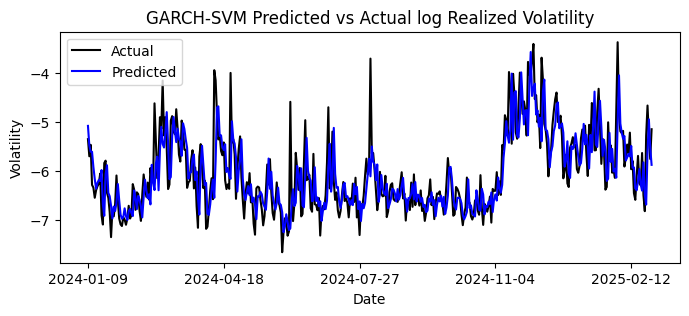

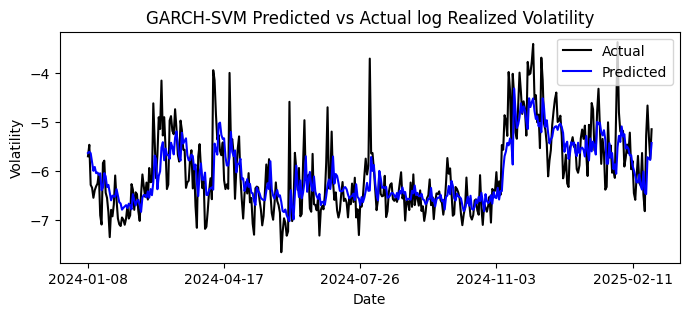

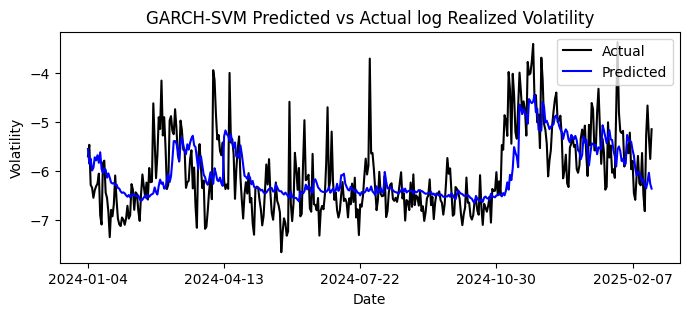

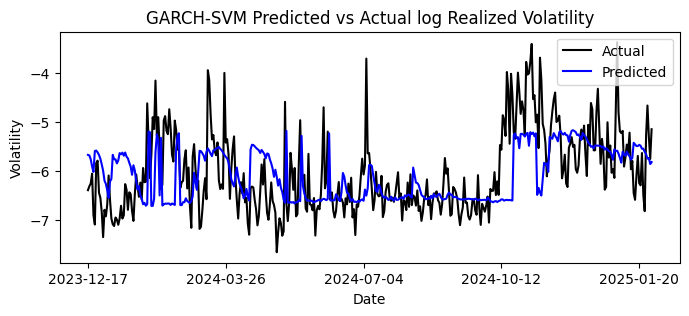

In [11]:
for h in [1,3,7,30]:
    print(f"Predicting for {h}D ahead")
    pred = get_pred(h)
    pred.to_csv(f'../res/{h}D/GARCH-SVM.csv')
    plot_pred(pred, h)